In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import TensorDataset, DataLoader

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import vgg16, vgg16_bn, resnet18, resnet34, resnet50, resnet101, resnet152

from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
from sklearn.metrics import f1_score

import seaborn as sn

from os import listdir, path
from PIL import Image
from collections import defaultdict
import csv
import re
import os

from IPython.display import display, clear_output, Image as IPython_Image

In [2]:
torch.cuda.is_available()

True

# Data loading

In [3]:
IMAGE_PATH = '../data/images'
LABEL_PATH = '../data/annotations'

# GIVEN DATASET
MEAN = (0.43672, 0.40107, 0.36762)
STD = (0.30139, 0.28781, 0.29236)

# IMAGENET
#MEAN = (0.485, 0.456, 0.406)
#STD = (0.229, 0.224, 0.225)

# RESNET
#MEAN = (0.485, 0.456, 0.406)
#STD = (0.229, 0.224, 0.225)
       
# Define default pos_weights for nn.BCEWithLogitsLoss(pos_weights).
label_pos_weights_for_loss = np.array([209.52631579, 55.87203791, 58.40594059, 16.77777778, 44.80152672, 5.25, 25.14379085, 5.75675676, 33.09090909, 2.15540363, 5.51465798, 163.38356164, 119., 37.46153846], dtype=np.float32)

In [4]:
def number_of_classes():
    return len(listdir(LABEL_PATH))

In [5]:
def get_class_map():
    ret = {}

    i = 0
    for fname in listdir(LABEL_PATH):
        img_class, _ = fname.split('.')
        ret[img_class] = i
        i += 1

    return ret

In [6]:
def write_labels_to_csv(name_of_set, label_array):
    filepath = f'../data/labels_{name_of_set}.csv'
    
    label_arr = np.array(label_array).astype(int)

    # Save 2D numpy array to csv file
    np.savetxt(filepath, label_arr, delimiter=',', fmt='%d')

In [7]:
def get_data(train_fr=.6, max_images_per_class=1e9):
    # mapping from class names to integers
    class_map = get_class_map()

    # create a dictionary to hold our label vectors
    n_classes = len(class_map.keys())
    img_to_class = defaultdict(lambda: np.zeros(n_classes))

    # another dictionary to hold the actual image data
    img_to_data = dict()
    
    # loop through all the annotations
    for fname in listdir(LABEL_PATH):
        img_class, _ = fname.split('.')
        print(f'Reading class: {img_class}')
        
        # open the annotation file
        i = 0
        with open(f'{LABEL_PATH}/{fname}', 'r') as fh:

            # get image ids from annotation file
            img_ids = fh.read().splitlines()
            
            # gather the images with labels
            for i, img_id in enumerate(img_ids):
                
                # let's not process images unnecessarily
                if not img_id in img_to_data:

                    img_path = f'{IMAGE_PATH}/im{img_id}.jpg'
                    img = Image.open(img_path)

                    # append to dict
                    img_to_data[img_id] = img.convert('RGB')

                # get one-hot encoded vector of image classes
                img_classes = img_to_class[img_id]

                # add new class to image vector
                img_class_id = class_map[img_class]
                img_classes[img_class_id] = 1

                # store the updated vector back
                img_to_class[img_id] = img_classes

                if i >= max_images_per_class:
                    break

                i += 1

    # load also all the images that do not have any labels
    i = 0
    print(f'Reading images without labels..')
    for fname in listdir(IMAGE_PATH):
        m = re.match('im(\d+)', fname)
        img_id = m.group(1)

        if img_id not in img_to_data:
            img_path = f'{IMAGE_PATH}/im{img_id}.jpg'
            img = Image.open(img_path)

            # append to dict
            img_to_data[img_id] = img.convert('RGB')

            if i >= max_images_per_class:
                break

            i += 1

    print('Creating train/valid/test split..')
    # collect data to a single array
    X = []
    y = []
    for img_id in img_to_data.keys():
        X.append(img_to_data[img_id])
        y.append(img_to_class[img_id])

    X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, train_size=train_fr, random_state=42)
    X_test, X_valid, y_test, y_valid = train_test_split(X_tmp, y_tmp, train_size=.5, test_size=.5, random_state=42)
    
    print('Done.')

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [8]:
class TransformingDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transforms=None):
        self.X = X
        self.y = y
        self.transforms = transforms

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img_data = self.X[idx]
        img_class = self.y[idx]

        if transforms:
            img_data = self.transforms(img_data)

        return img_data, img_class

# Models

In [9]:
class TwoLayerModel(nn.Module):
    def __init__(self, n_input, n_hidden1, n_hidden2, n_classes):
        super().__init__()
        self.bs = bs
        self.input_layer = nn.Linear(n_input, n_hidden1)
        self.hidden1 = nn.Linear(n_hidden1, n_hidden2)
        self.hidden2 = nn.Linear(n_hidden2, n_classes)
        self.relu = nn.ReLU()
        self.bn0 = nn.BatchNorm1d(n_input)
        self.bn1 = nn.BatchNorm1d(n_hidden1)
        self.bn2 = nn.BatchNorm1d(n_hidden2)

    def forward(self, x):
        x = self.bn0(x)
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.hidden2(x)

        return x

In [10]:
class OneLayerModel(nn.Module):
    def __init__(self, n_input, n_hidden, n_classes):
        super().__init__()

        self.input_layer = nn.Linear(n_input, n_hidden)
        self.hidden = nn.Linear(n_hidden, n_classes)
        self.relu = nn.ReLU()
        self.bn0 = nn.BatchNorm1d(n_input)
        self.bn1 = nn.BatchNorm1d(n_hidden)

    def forward(self, x):
        print(f'X.SHAPE: {x.shape}')
        x = self.bn0(x)
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.hidden(x)

        return x

In [11]:
class ConvNetModel(nn.Module):
    def __init__(self, n_classes, keep_prob=.5):
        super(ConvNetModel, self).__init__()
        # Common layers used multiple times
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=1-keep_prob)
        
        # Unique layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=3, stride=1, padding=1) #(n samples, channels, height, width)
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=14, kernel_size=3, stride=1, padding=1)
        self.fc3 = nn.Linear(in_features=256*4*14, out_features=n_classes)
        
    def forward(self, x):
        x = x.reshape(-1, 3, 128, 128)
        
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        
        out = out.reshape(out.size(0), -1)  # Flatten for FC
        out = self.fc3(out)
        return out    

# Training and evaluation functions

In [12]:
def evaluate(dataloader, model, criterion, device, threshold=0.5):
    model.eval()

    f1_scores = []
    losses = []

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)

            loss = criterion(y_pred, y)
            losses.append(loss)

            with torch.no_grad():
                score = f1_score(y.cpu() == 1, y_pred.cpu() > threshold, average='micro')
                f1_scores.append(score)

    model.train()

    return torch.mean(torch.tensor(losses)), torch.mean(torch.tensor(f1_scores))

In [13]:
def train(train_dataloader, valid_dataloader, model, optimizer, scheduler, criterion, device, n_epochs=50, verbose=True):
    model.train()

    if verbose:
        fmt = '{:<5} {:12} {:12} {:<9} {:<9}'
        print(fmt.format('Epoch', 'Train loss', 'Valid loss', 'Train F1', 'Valid F1'))

    for epoch in range(n_epochs):
        
        for i, batch in enumerate(train_dataloader):
            X, y = batch
            
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            print(f'Epoch: {epoch+1}, iteration: {i+1}, loss: {loss}')

        if verbose:
            train_loss, train_score = evaluate(train_dataloader, model, criterion, device)
            valid_loss, valid_score = evaluate(valid_dataloader, model, criterion, device)

            fmt = '{:<5} {:03.10f} {:03.10f} {:02.7f} {:02.7f}'
            print(fmt.format(epoch, train_loss, valid_loss, train_score, valid_score))
            
    print('Done training!')

# Visualization functions

In [14]:
def visualize_true_positives(img_label, model, device, dataloader, n_to_show=10, threshold=0.75):

    class_map = get_class_map()
    img_class = class_map[img_label]

    def predicate(pred_classes, true_classes):
        return True if img_class in pred_classes and img_class in true_classes else False

    visualize_predictions(model, device, dataloader, n_to_show=n_to_show, predicate=predicate)

In [15]:
def visualize_true_negatives(img_label, model, device, dataloader, n_to_show=10, threshold=0.75):

    class_map = get_class_map()
    img_class = class_map[img_label]

    def predicate(pred_classes, true_classes):
        return True if not img_class in pred_classes and not img_class in true_classes else False

    visualize_predictions(model, device, dataloader, n_to_show=n_to_show, predicate=predicate)

In [16]:
def visualize_false_positives(img_label, model, device, dataloader, n_to_show=10, threshold=0.75):

    class_map = get_class_map()
    img_class = class_map[img_label]

    def predicate(pred_classes, true_classes):
        return True if img_class in pred_classes and not img_class in true_classes else False

    visualize_predictions(model, device, dataloader, n_to_show=n_to_show, predicate=predicate)

In [17]:
def visualize_false_negatives(img_label, model, device, dataloader, n_to_show=10, threshold=0.75):

    class_map = get_class_map()
    img_class = class_map[img_label]

    def predicate(pred_classes, true_classes):
        return True if not img_class in pred_classes and img_class in true_classes else False

    visualize_predictions(model, device, dataloader, n_to_show=n_to_show, predicate=predicate)

In [18]:
def visualize_predictions(model, device, dataloader, mean=MEAN, std=STD, n_to_show=10, threshold=0.5, predicate=None):
    
    if predicate == None:
        predicate = lambda: True

    class_to_label = { v: k for k, v in get_class_map().items() }
    
    # https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/5
    inv_transform = transforms.Compose([
        transforms.Normalize(mean = -1 * np.multiply(mean, std), std=np.divide(1, std))
    ])
    
    n_shown = 0
    for i, batch in enumerate(dataloader):
        X, y = batch
        X = X.to(device)

        y_pred_raw = model(X).cpu()
        y_pred = y_pred_raw > threshold 
        y = y == 1
        
        for i in range(len(y)):
            pred_classes = np.where(y_pred[i] == 1)[0]
            true_classes = np.where(y[i] == 1)[0]
            
            if not predicate(pred_classes, true_classes):
                continue

            show_image_with_predictions(X[i], true_classes, pred_classes)

            n_shown += 1
            
            if n_shown >= n_to_show:
                return            

In [19]:
def show_image_with_predictions(X, true_classes, pred_classes, mean=MEAN, std=STD):
    
    class_map = get_class_map()
    class_to_label = { v: k for k, v in class_map.items() }

    true_classes_str = ', '.join([class_to_label[i] for i in true_classes])
    pred_classes_str = ', '.join([class_to_label[i] for i in pred_classes])

    # https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/5
    inv_transform = transforms.Normalize(mean = -1 * np.multiply(mean, std), std=np.divide(1, std))

    img = inv_transform(X.cpu()) # inverse transforms
    img = img.permute(2, 1, 0)   # BGR -> RGB
    img = np.rot90(img, 3)

    plt.title(f'True: {true_classes_str}, Predictions: {pred_classes_str}')
    plt.imshow(img)
    plt.pause(0.001)

In [20]:
def predict_X(fr, threshold=0.5):
    
    y_hat = fr > threshold
    
    return y_hat if (np.sum(y_hat) > 0) else fr == np.max(fr)

def predict(model, device, dataloader):
    
    ys_all = []  # Array of np.array(14) 
    y_hats_all = []
    
    for i, batch in enumerate(dataloader):
        
        Xs, ys = batch
        Xs = model(Xs.to(device))
        y_hats = np.apply_along_axis(predict_X, axis=1, arr=Xs.cpu().detach().numpy())
        
        y_hats_all.extend(y_hat for y_hat in y_hats)
        ys_all.extend(y.numpy() for y in ys==1)

    return np.array(ys_all), np.array(y_hats_all)

def visualize_confusion_matrix(y_true, y_pred, labels, file_path):

    plt.ioff()
    
    # Get confusion matrices
    cn_tensor = skm.multilabel_confusion_matrix(y_true, y_pred)
    
    # Get precision, recall, f1-score
    scores = skm.classification_report(y_true, y_pred, output_dict=True)

    fig, ax = plt.subplots(nrows=5, ncols=3,sharey=True, figsize=(20, 20), 
                           gridspec_kw={'hspace': 0.3, 'wspace': 0.0})
    gn = ['True Neg','False Pos','False Neg','True Pos']
    n = cn_tensor[0].sum()
    
    # Loop all labels
    for i, cn_matrix in enumerate(cn_tensor):

        j, k = int(i/3), i%3
        
        # Annotations
        annot = np.asarray(
            ['{}\n{:0.0f}\n{:.2%}'.format(gn[i], x, x/n) for i, x in enumerate(cn_matrix.flatten())]
        ).reshape(2,2)
        
        # Plot heatmap
        sn.heatmap(cn_matrix, annot=annot, fmt='', cmap='Blues', ax=ax[j, k])
        
        # Precision, recall, f1-score
        title = '{}\nprec.={:.3}, rec.={:.3}, f1={:.3}'.format(
            labels[i], scores[str(i)]['precision'], scores[str(i)]['recall'], scores[str(i)]['f1-score'])
        ax[j, k].set_title(title)
        
    plt.savefig(file_path, bbox_inches='tight')
    plt.close()

# Do the magic!

In [21]:
if torch.cuda.is_available():
    print('Using GPU!')
    device = torch.device('cuda')
else:
    print('Using CPU')
    device = torch.device('cpu')

lr = 0.01
n_epochs = 20
bs = 64
n_classes = len(get_class_map().keys())

Using GPU!


## Create and save / load dataloaders from disk

In [22]:
max_images_per_class = int(1e9)
#max_images_per_class = 200

transformations = {
    'train': transforms.Compose([
        transforms.RandomIndividualApply([
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomRotation((-10, 10)),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
            transforms.RandomGrayscale(p=0.1),
            transforms.RandomPerspective(),
        ], p=0.5),
        transforms.ToTensor(),                
        transforms.Normalize(mean=MEAN, std=STD)            
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ]),
}

if os.path.isfile(f'X_train_n{max_images_per_class}.dat'):
    X_train, X_valid, X_test, y_train, y_valid, y_test = get_data(max_images_per_class=max_images_per_class)
    torch.save(X_train, f'../data/X_train_n{max_images_per_class}.dat')
    torch.save(X_valid, f'../data/X_valid_n{max_images_per_class}.dat')
    torch.save(X_test, f'../data/X_test_n{max_images_per_class}.dat')
    torch.save(y_train, f'../data/y_train_n{max_images_per_class}.dat')
    torch.save(y_valid, f'../data/y_valid_n{max_images_per_class}.dat')
    torch.save(y_test, f'../data/y_test_n{max_images_per_class}.dat')
else:
    X_train = torch.load(f'../data/X_train_n{max_images_per_class}.dat')
    X_valid = torch.load(f'../data/X_valid_n{max_images_per_class}.dat')
    X_test = torch.load(f'../data/X_test_n{max_images_per_class}.dat')
    y_train = torch.load(f'../data/y_train_n{max_images_per_class}.dat')
    y_valid = torch.load(f'../data/y_valid_n{max_images_per_class}.dat')
    y_test = torch.load(f'../data/y_test_n{max_images_per_class}.dat')

train_dataloader = DataLoader(
    TransformingDataset(X_train, y_train, transforms=transformations['train']),
    shuffle=True,
    batch_size=bs)

valid_dataloader = DataLoader(
    TransformingDataset(X_valid, y_valid, transforms=transformations['valid']),
    shuffle=True,
    batch_size=bs)

test_dataloader = DataLoader(
    TransformingDataset(X_test, y_test, transforms=transformations['test']),
    shuffle=True,
    batch_size=bs)

## Pretrained models

NB: The mean and std in transformations most probably need to be the same as for VGG and RESNET. Not 100% sure about this. Something to investigate!

More models here: https://pytorch.org/docs/stable/torchvision/models.html

If the models do not start to converge, try lowering the learning rate!

_VGG16_

Currently getting validation f1 scores around 0.67. 

Now around 0.71 with one cycle policy.

Surprisingly after quick testing the vgg16_bn (with BatchNorm layers) did not do as well? Maybe more to investigate here.

In [23]:
if False:
    model = vgg16(pretrained=True).to(device)

    for param in model.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(),
        nn.Linear(4096, 2048),
        nn.ReLU(),
        nn.Linear(2048, 14),
    ).to(device)

_RESNET_


In [24]:
if False:
    model = resnet18(pretrained=True).to(device)

    for layer in model.children():
        layer.requires_grad = False

    model.fc = nn.Linear(512, 14).to(device)

In [25]:
if False:
    model = resnet34(pretrained=True).to(device)

    for layer in model.children():
        layer.requires_grad = False

    model.fc = nn.Linear(512, 14).to(device)

In [26]:
if False:
    model = resnet50(pretrained=True).to(device)

    for layer in model.children():
        layer.requires_grad = False

    model.fc = nn.Linear(2048, 14).to(device)

In [27]:
if True:
    model = resnet101(pretrained=True).to(device)

    for layer in model.children():
        layer.requires_grad = False

    model.fc = nn.Linear(2048, 14).to(device)

In [28]:
if False:
    model = resnet152(pretrained=True).to(device)

    for layer in model.children():
        layer.requires_grad = False

    model.fc = nn.Linear(2048, 14).to(device)

## Train a model or load an existing model from disk

In [29]:
n_epochs = 5

In [30]:
# loss function
pos_weight = torch.from_numpy(label_pos_weights_for_loss).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# learning rate and momentum will be overriden by the scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.000001,
    base_momentum=0.5,
    max_momentum=0.95,
    steps_per_epoch=len(train_dataloader),
    epochs=n_epochs,
)

In [36]:
# Paths for model saving and loading

# ResNet 101
#model_save_path = '../data/resnet-valid-acc-aug-0.70.pth'
#model_save_path = '../data/resnet-101-valid-acc-0.73.pth'

#model_save_path = '../data/resnet-152-valid-acc-0.722.pth'
#model_save_path = '../data/resnet-152-valid-acc-0.727.pth'

# VGG16
#model_save_path = '../data/vgg16-9epochs-valid-acc-0.66.pth'

# Whole model
#model_whole_save_path = '../data/vgg16-7epochs-valid-acc-0.703.pth'

In [37]:
# Plain model saving and loading (only state dictionary).
#torch.save(model.state_dict(), model_save_path)
#model.load_state_dict(torch.load(model_save_path, map_location=torch.device(device)))

<All keys matched successfully>

In [33]:
# Save an entire model (not just the state dict)
#torch.save(model, model_whole_save_path)

In [34]:
# Load an entire model (not just the state dict)
#model = torch.load(model_whole_save_path)
#model.eval()

In [ ]:
# This is for trying to train all the layers...
#for param in model.parameters():
#    param.requires_grad = True

In [ ]:
%time train(train_dataloader, valid_dataloader, model, optimizer, scheduler, criterion, device, n_epochs=n_epochs)

In [ ]:
evaluate(valid_dataloader, model, criterion, device, threshold=0.75)

In [ ]:
# This is for finding the optimal threshold.
# Haven't proved out to be very useful yet.
if True:
    f1_scores = []
    for threshold in np.arange(0.05, 1, 0.05):
        _, f1 = evaluate(valid_dataloader, model, criterion, device, threshold=threshold)
        f1_scores.append(f1)
        print(f'threshold: {threshold}, f1 score: {f1}')

    plt.plot(np.arange(0.05, 1, 0.05), f1_scores)

# Visualization and evaluation

### Show some images with predictions

In [ ]:
visualize_predictions(model, device, test_dataloader, n_to_show=5, threshold=0.75)

#### TP/FP/TN/FN

In [38]:
img_label = 'baby'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


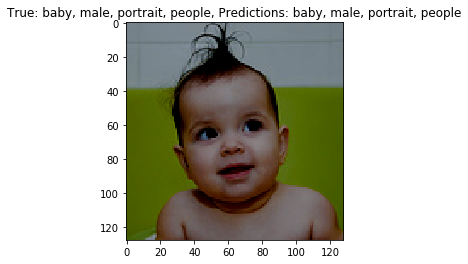

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


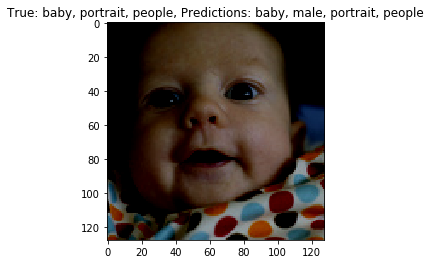

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


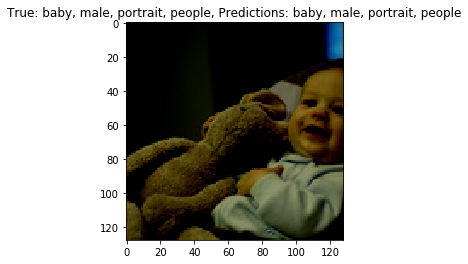

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


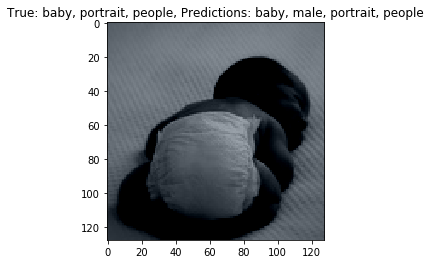

In [39]:
visualize_true_positives(img_label, model, device, valid_dataloader, n_to_show=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


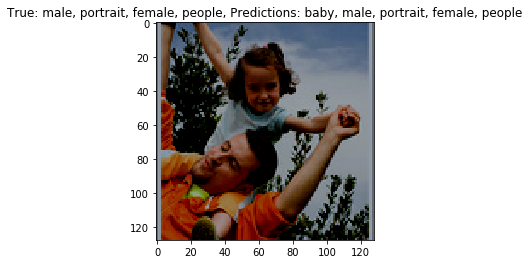

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


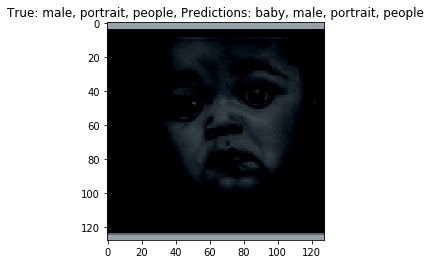

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


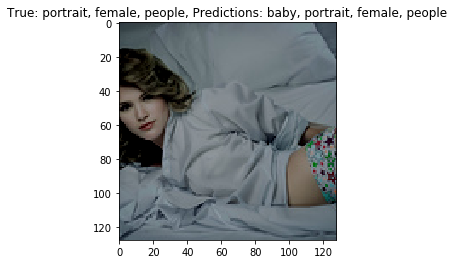

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


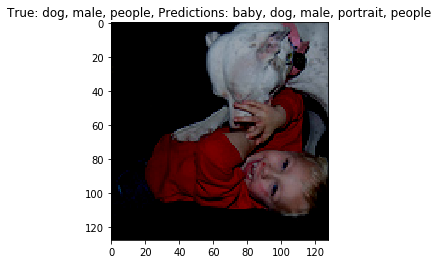

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


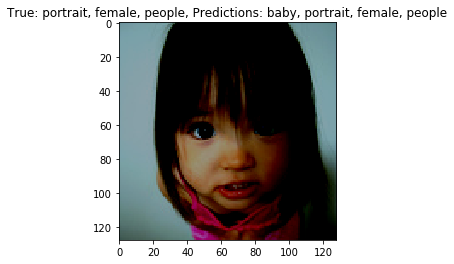

In [40]:
visualize_false_positives(img_label, model, device, valid_dataloader, n_to_show=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


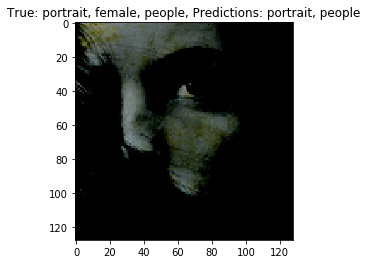

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


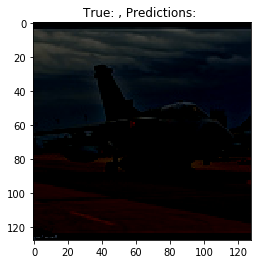

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


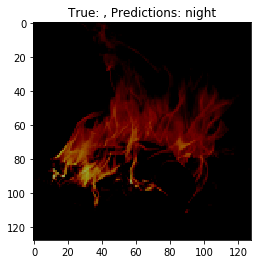

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


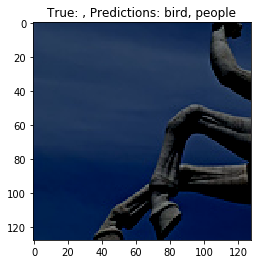

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


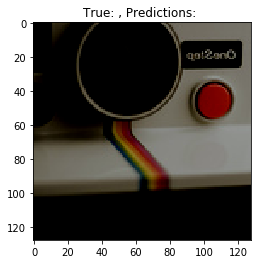

In [41]:
visualize_true_negatives(img_label, model, device, valid_dataloader, n_to_show=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


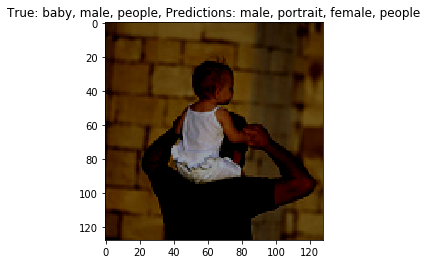

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


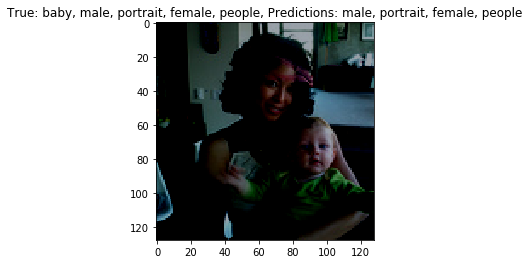

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


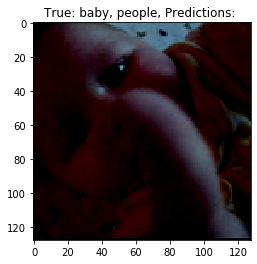

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


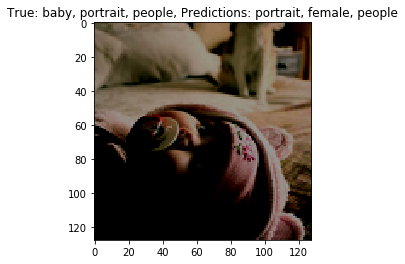

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


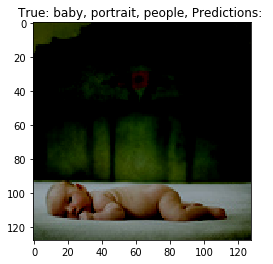

In [42]:
visualize_false_negatives(img_label, model, device, valid_dataloader, n_to_show=5)

### Confusion matrix

In [ ]:
re_predict = True

if re_predict:

    # Predict
    y_true, y_pred = predict(model, device, valid_dataloader)
    np.save(f'../data/valid_true_labels.npy', y_true)
    np.save(f'../data/valid_pred_labels.npy', y_pred)
    
    # Save classification report
    with open(f'../data/valid_classification_report.txt', 'w') as file:
        file.write(skm.classification_report(y_true, y_pred))
    
    # Save confusion matrix plot
    labels = [k for k, v in get_class_map().items()]
    visualize_confusion_matrix(y_true, y_pred, labels, f'../data/valid_confusion_matrix.png')

In [ ]:
# Show classification report
with open(f'../data/valid_classification_report.txt', 'r') as file:
    report = ''.join(file.readlines())
    print(report)

In [ ]:
# Show confus|ion matrix plot
IPython_Image(filename=f'../data/valid_confusion_matrix.png', width=1000)